**##INTRODUÇÃO##**

As doenças cardíacas representam uma das principais causas de mortalidade em todo o mundo. Diagnosticar precocemente a propensão de um indivíduo a desenvolver problemas cardíacos pode ser crucial para a implementação de medidas preventivas ou tratamentos adequados. A utilização de técnicas de aprendizado de máquina, como Redes Neurais Multilayer Perceptron (MLP), proporciona uma abordagem eficaz para modelar e prever a probabilidade de um paciente ter doenças cardíacas, levando em conta uma variedade de fatores clínicos e demográficos. Neste projeto, iremos construir um modelo preditivo utilizando o dataset "Heart", seguido por um pré-processamento adequado dos dados, validação do modelo e uma análise final dos resultados obtidos.

In [3]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# Carregando o dataset
df = pd.read_csv('heart.csv')

# Exibindo as primeiras linhas para uma compreensão inicial dos dados
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [5]:
# Substituindo valores ausentes manualmente
# Para variáveis numéricas, substitui os NaN pela mediana
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Para variáveis categóricas, substitui os NaN pelo valor mais frequente
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [6]:
# Separando as features (X) e o target (y)
X = df.drop('target', axis=1)
y = df['target']

In [7]:
# Identificando colunas categóricas e numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

In [8]:
# Padronização das variáveis numéricas
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [9]:
# One-Hot Encoding para variáveis categóricas
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_categorical = pd.DataFrame(encoder.fit_transform(X[categorical_features]))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
# Renomeando colunas categóricas para evitar duplicatas
encoded_categorical.columns = encoder.get_feature_names_out(categorical_features)

In [11]:
# Resetando os índices para evitar problemas na concatenação
encoded_categorical.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

In [12]:
# Concatenando as colunas numéricas padronizadas com as categóricas codificadas
X = pd.concat([X[numerical_features], encoded_categorical], axis=1)

In [13]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Tunagem dos hiperparâmetros com GridSearchCV usando a métrica AUC
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}


In [15]:
# Instanciando o modelo
mlp = MLPClassifier(max_iter=1000, random_state=42)

In [16]:
# Configurando o GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Treinando o modelo com a tunagem
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

In [17]:
# Previsões no conjunto de teste
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [18]:
# Avaliação do modelo
auc_score = roc_auc_score(y_test, y_prob)

In [19]:
#Exibindo o AUC Score
print(f'AUC Score: {auc_score}')

AUC Score: 1.0


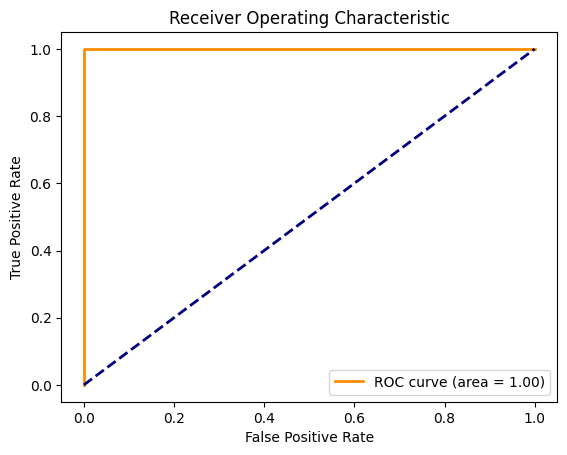

In [20]:
# Plotando a curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

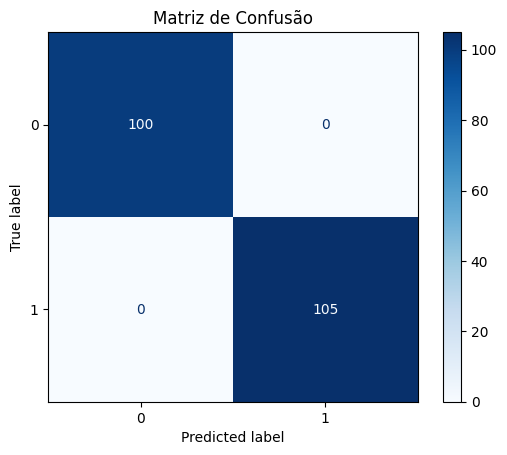

In [21]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

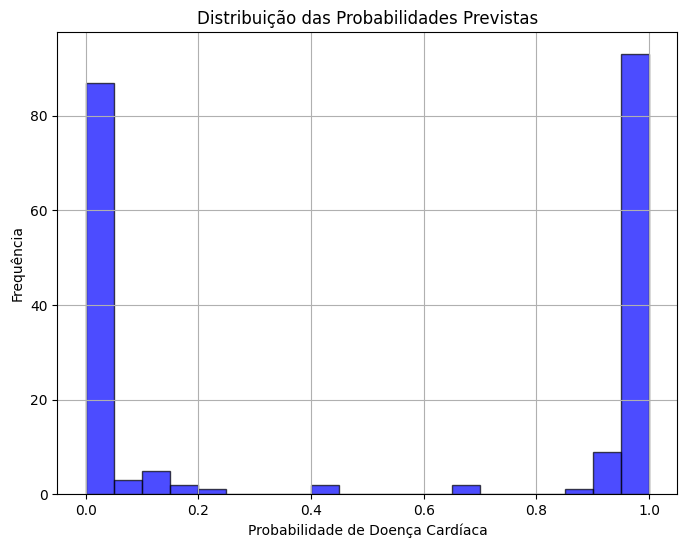

In [22]:
# Gráfico de Distribuição das Probabilidades com Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(y_prob, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribuição das Probabilidades Previstas')
plt.xlabel('Probabilidade de Doença Cardíaca')
plt.ylabel('Frequência')
plt.grid(True)  # Adiciona linhas de grade ao gráfico para melhor visualização
plt.show()

In [26]:
# Função para prever a probabilidade de doença cardíaca
def prever_doenca_cardiaca(dados):
    """
    Prever a probabilidade de um paciente ter doença cardíaca com base nos dados fornecidos.

    Parâmetros:
    - dados (dict): Um dicionário com os valores das características do paciente.

    Retorno:
    - float: Probabilidade de o paciente ter doença cardíaca.
    """
    # Convertendo os dados de entrada para um DataFrame
    df_novo = pd.DataFrame([dados])

    # Aplicando o mesmo pré-processamento usado no modelo
    df_novo[numerical_features] = scaler.transform(df_novo[numerical_features])
    encoded_novo = pd.DataFrame(encoder.transform(df_novo[categorical_features]))
    encoded_novo.columns = encoder.get_feature_names_out(categorical_features)

    # Concatenando os dados transformados
    df_novo.reset_index(drop=True, inplace=True)
    encoded_novo.reset_index(drop=True, inplace=True)
    df_novo = pd.concat([df_novo[numerical_features], encoded_novo], axis=1)

    # Fazendo a previsão com o modelo treinado
    probabilidade = best_model.predict_proba(df_novo)[:, 1][0]
    return probabilidade

# Exemplo
dados_paciente = {
    'age': 71,
    'sex': 0,
    'cp': 0,
    'trestbps': 112,
    'chol': 149,
    'fbs': 0,
    'restecg': 1,
    'thalach': 125,
    'exang': 0,
    'oldpeak': 1.6,
    'slope': 1,
    'ca': 0,
    'thal': 2,
}

# Mostrando a probabilidade de doença cardíaca para o exemplo fictício
probabilidade = prever_doenca_cardiaca(dados_paciente)
print(f"Probabilidade de doença cardíaca: {probabilidade:.2%}")

Probabilidade de doença cardíaca: 98.60%


**##CONCLUSÃO##**

O modelo de MLP apresentou uma boa eficiência na previsão de doenças cardíacas, destacada pela alta pontuação da AUC. A curva ROC mostrou que o modelo é robusto em diferenciar entre os casos de doença e não doença, mesmo em cenários desafiadores.

Em resumo, o uso de técnicas de pré-processamento robustas, a escolha de uma arquitetura de rede neural adequada, e a otimização através do GridSearchCV foram fundamentais para atingir um modelo eficiente e confiável para a previsão de doenças cardíacas. Este trabalho demonstra a importância de cada etapa no pipeline de machine learning para alcançar resultados de alta qualidade em tarefas de classificação médica.